# Pipeline Main Executable
This is the main executable for the integrated data pipeline

**Author: Florian Lietz**

## General imports of modules and libraries

In [16]:
from os import path
import pandas as pd
import numpy as np
from stages.utils.utils import DataCleaner
from stages.TM.textmining import CasesList, lemmatize
from stages.PM.processmining import importCSVToLog, heuristicsMiner, previewAndSave, computeMetrics, previewAndSaveHeuristicsNet
from stages.LPA.learningprocessanalysis import getEvaluationList, fitParameters, objective, objective_cube, fitAndPlot
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Data Input and Configuration of Data Pipeline

In [17]:
# first element empty as gensim LDA model starts indexing with 1
topicLabels = [
    None, "Initial Application by Candidate",
    "Automatic Reply", "Internal Communication / Clarification of Requirements",
    "Organizational Communication with Candidate for Clarification of Skills or Interview Invitation",
    "Job Offer / Contract Negotiation", "Application Declined"
]
# Topics to discover in LDA
n_topics = 10
# Specification of Input File
infile = path.join("resources", "dataset", "Mail_ApplicationDataset_-2.csv")

## Import, preprocessing, case clustering


In [18]:
# import NLD file
inputFile = pd.read_csv(infile, delimiter=";")
cleaner = DataCleaner(
    removeURLs=True,
    removeMultWhitespace=True,
    lowercasing=False,
    dateFormat="%Y-%m-%d %H:%M:%S"
)
cleaner.apply(inputFile)
casesList = CasesList.groupCases(file=inputFile, maxDays=8)

100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 1223.02it/s]


## Text Mining: Step 1 - Preprocesing


In [19]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import gensim
import gensim.corpora
from gensim.utils import pickle, simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

stopwords = stopwords.words("english")
corpora_msg = casesList.getCorpora()

# Lemmatize
corpora_lemmatized = lemmatize(corpora_msg)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flietz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text Mining: Step 2 - LDA

In [20]:
id2word = gensim.corpora.Dictionary(corpora_lemmatized)
corp = [id2word.doc2bow(text) for text in corpora_lemmatized]
n_topics = 10

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corp,
    id2word=id2word,
    num_topics=n_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto"
)

## Text Mining: Step 2a - Visualize using pyLDAvis


In [21]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(
   lda_model,
   corp,
   id2word,
   mds="mmds",
   R=20
)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.254674 -0.263754       1        1  26.635901
7     -0.091028 -0.326402       2        1  22.485897
5     -0.280601 -0.226422       3        1  14.709509
9     -0.331743  0.079366       4        1  13.170854
6      0.086780 -0.076145       5        1   7.727658
2      0.352012  0.031573       6        1   5.226199
0      0.093901  0.305747       7        1   4.104320
4     -0.067893  0.094368       8        1   2.085600
8     -0.084123  0.242932       9        1   2.010124
3      0.068021  0.138737      10        1   1.843938, topic_info=            Term        Freq       Total Category  logprob  loglift
2    application  256.000000  256.000000  Default  20.0000  20.0000
38         thank  112.000000  112.000000  Default  19.0000  19.0000
654       Carter   54.000000   54.000000  Default  18.0000  18.0000
192     Engineer   82.000000   82.000000  Default  17.0000  17.0000
189         good   41.000000   41.000000  Default  16.0000  16.0000
..           ...         ...         ...      ...      ...      ...
133       screen    2.235709   21.810702  Topic10  -3.8000   1.7154
100  responsible    0.873110    5.640411  Topic10  -4.7403   2.1276
78          soon    1.353345   20.739421  Topic10  -4.3020   1.2638
63        Mister    1.554811   41.155594  Topic10  -4.1632   0.7173
88      question    1.227619   29.823064  Topic10  -4.3995   0.8031

[315 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
142       2  0.937401       .ical
642       2  0.940285     09:30am
381       6  0.800293  Accountant
115       1  0.922676     Alright
49        1  0.936571   Applicant
...     ...       ...         ...
141       5  0.047014        work
323       9  0.563978     working
276       1  0.446557        year
276       5  0.267934        year
276       9  0.178623        year

[365 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 6, 10, 7, 3, 1, 5, 9, 4])

## Text Mining: Step 3 - Assign detected labels to each message


In [22]:
for case in casesList:
    for message in case.messages:
        cor = f"{message.subject} {message.content}"
        new_text_corpus = id2word.doc2bow(cor.split())
        highestPercentageLabel = max(lda_model[new_text_corpus], key=lambda x:x[1])[0]
        if (message.from_.split("@")[1] == message.to.split("@")[1]):
            # clustering of messages within the organization, according on TOPIC_LABELS in textmining.py
            message.detectedLabel = 3
        else:
            message.detectedLabel = highestPercentageLabel

## Text Mining: Step 4 - Generate Artificial Event Log

In [23]:
logname = casesList.generateEventLog(
    name=datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    filePath=path.join("out", "art_event_logs"),
    topicLabels=topicLabels
)

## Text Mining: Step 4a - Create Log for debugging

In [24]:
debuglogname = casesList.generateDebugLog(
    name=datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    filePath=path.join("out", "debug_event_logs")
)

## Process Mining: Step 1 - Import Artificial Event Log and use as Input to Miner

In [25]:
log = importCSVToLog(filepath=path.join("out", "art_event_logs", logname))
net, im, fm = heuristicsMiner(log)

Imported 312 events with 26 cases.


## Process Mining: Step 2 - Setup Heuristic Miner, Generate Metrics and Print Results

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

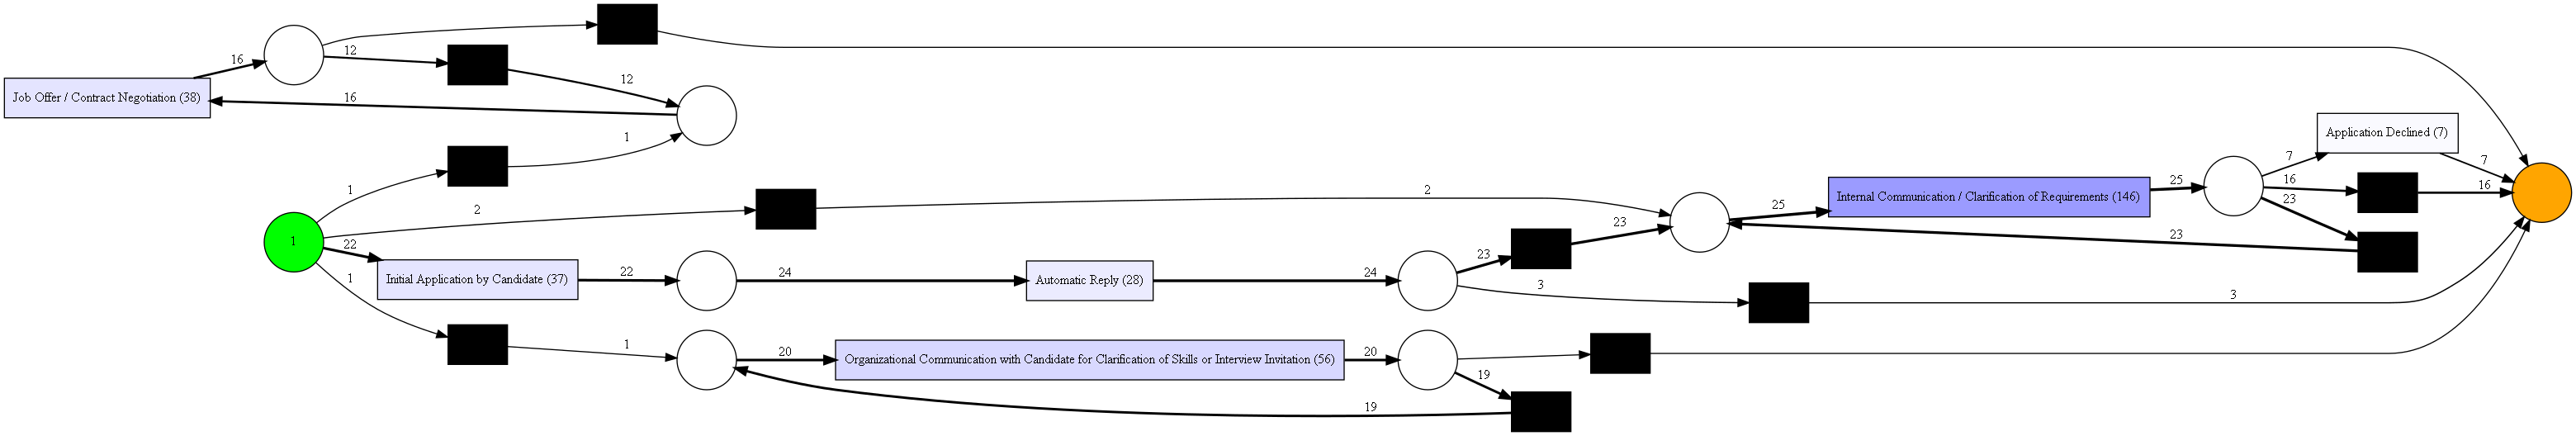

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/124 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 11.538461538461538, 'average_trace_fitness': 0.9083925027414678, 'log_fitness': 0.9040852575488455, 'percentage_of_fitting_traces': 11.538461538461538}
Precision: 0.7435897435897436
Generalization: 0.5696498464195482
Simplicity: 0.6585365853658536


In [26]:
# create png for preview and svg to save to file
previewAndSave(log, net, im, fm)

# Compute Metrics
fitness, prec, gen, simp = computeMetrics(log, net, im, fm)

print(f"Fitness: {fitness}")
print(f"Precision: {prec}")
print(f"Generalization: {gen}")
print(f"Simplicity: {simp}")

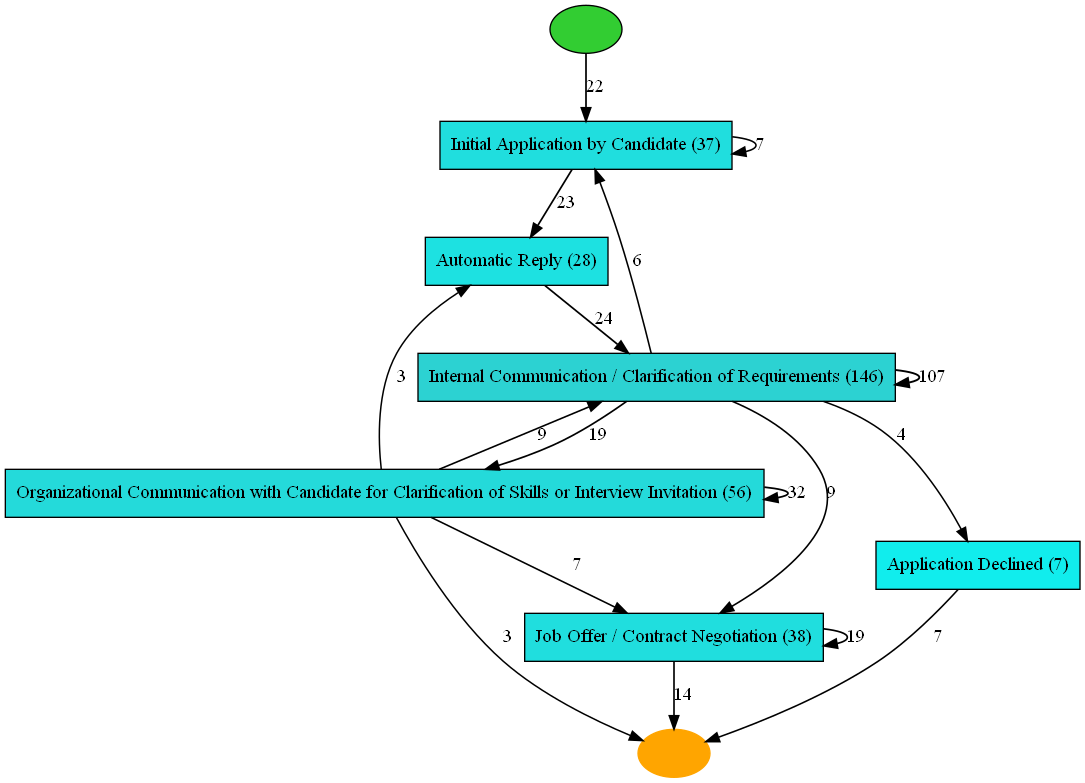

In [27]:
previewAndSaveHeuristicsNet(log)

## Learning Process Analysis Step 1: Get LPA metrics for Junior and Expert HR practitioner

In [28]:
p1_id = "j.parker@ziegler-cat.com"
p2_id = "j.nielsen@ziegler-cat.com"
# Calculate normalized evaluation score for each HR practitioner for each respective case
evaluation_list_p1, evaluation_list_p2 = getEvaluationList(p1_id, p2_id, casesList)

frank.garcia@hotmail.net 2018-08-02 19:35:00 2018-08-06 13:21:00
e.johnson@live.com 2018-10-13 22:11:00 2018-10-22 08:44:00
l.rodriguez@gmail.com 2019-01-02 12:33:00 2019-01-14 15:54:00
benjamin.moore@abcmail.com 2019-04-02 08:11:00 2019-04-16 11:00:00
brandon.lee@onemail.net 2019-07-04 22:29:00 2019-07-16 17:05:00
lisa.young@outlook.com 2019-07-25 06:12:00 2019-07-28 09:11:00
jennifer.wright@live.com 2019-09-18 17:11:00 2019-09-27 16:59:00
manuel.scott@live.net 2019-11-08 11:47:00 2019-11-22 09:06:00
jacob.green@outlook.com 2020-01-07 22:16:00 2020-01-18 16:05:00
nora.hill@one.net 2020-03-05 09:45:00 2020-03-12 10:14:00


## Learning Process Analysis - Step 2: Curve Fitting and Plot of Results

Employee 1: y = 0.0011232975223384857 * x + -3.137711703208047e-06 * x^2 + 2.8237198126045635e-09 x^3 + 0.366832418984279
Employee 2: y = -0.002195060192858051 * x + 5.3423776187696664e-06 * x^2 + -2.958191065577609e-09 x^3 + 0.7790210978355739


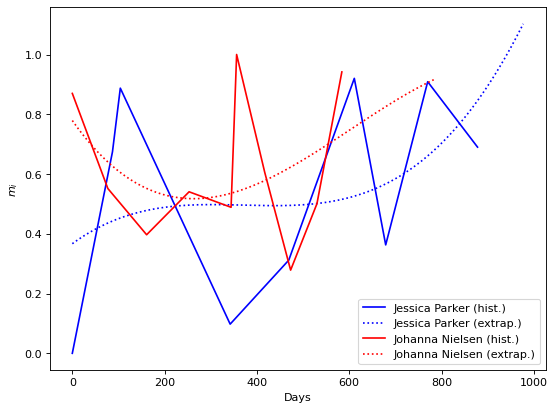

In [29]:
a1, a2, b1, b2, c1, c2, a1c, a2c, b1c, b2c, c1c, c2c, d1c, d2c = fitParameters(evaluation_list_p1, evaluation_list_p2)
print(f"Employee 1: y = {a1c} * x + {b1c} * x^2 + {c1c} x^3 + {d1c}")
print(f"Employee 2: y = {a2c} * x + {b2c} * x^2 + {c2c} x^3 + {d2c}")

# Plot score and fit curve
plt = fitAndPlot(evaluation_list_p1, evaluation_list_p2, a1, a2, b1, b2, c1, c2, a1c, a2c, b1c, b2c, c1c, c2c, d1c, d2c)